## Imports y dependencias

In [14]:
import os
import subprocess
import logging
from google.cloud import bigquery, storage
import google.auth

import copy
import requests
import json
import math
from collections import Counter
import pandas as pd
import polars as pl
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import optuna
import shap
shap.plots.initjs()
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module="shap")

# from ydata_profiling import ProfileReport

import re
import joblib
import time
from datetime import timedelta

from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE
from sklearn.impute import SimpleImputer
from scipy.stats import uniform, randint
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_val_score
 
credentials, your_project_id = google.auth.default(
    scopes=["https://www.googleapis.com/auth/cloud-platform"]
)
 
#nuevo
# Make clients.
bqclient = bigquery.Client(project=os.environ.get("CLOUD_ML_PROJECT_ID"))
bqstorageclient = storage.Client(project=os.environ.get("CLOUD_ML_PROJECT_ID"))

### Funciones desarrolladas

In [15]:
#FUNCIÓN SMOTE
def imputar_nulos(X, estrategia_imputacion="median"):
    """
    Imputa valores NaN en X.

    Parámetros:
        X (pd.DataFrame): características con posibles NaNs
        estrategia_imputacion (str): "mean", "median" o "most_frequent"

    Retorna:
        X_imputado (pd.DataFrame): DataFrame con valores imputados
    """
    if not isinstance(X, pd.DataFrame):
        raise ValueError("X debe ser un DataFrame para imputación automática.")

    imputer = SimpleImputer(strategy=estrategia_imputacion)
    X_imputado_np = imputer.fit_transform(X)
    X_imputado = pd.DataFrame(X_imputado_np, columns=X.columns)

    return X_imputado


def balancear_con_smote(X_imputado, y, random_state=42, ratio_minoria=0.7):
    """
    Aplica SMOTE para balancear las clases con una proporción personalizada.

    Parámetros:
        X_imputado (pd.DataFrame): características ya imputadas
        y (pd.Series o array-like): variable objetivo
        random_state (int): semilla para reproducibilidad
        ratio_minoria (float): proporción deseada de la clase minoritaria respecto a la mayoritaria

    Retorna:
        X_res (pd.DataFrame), y_res (pd.Series): conjuntos balanceados
    """
    if not isinstance(X_imputado, pd.DataFrame):
        raise ValueError("X_imputado debe ser un DataFrame.")

    if not hasattr(y, "name") or y.name is None:
        y = pd.Series(y, name="target")

    smote = SMOTE(random_state=random_state, sampling_strategy=ratio_minoria)
    X_res_np, y_res_np = smote.fit_resample(X_imputado, y)

    X_res = pd.DataFrame(X_res_np, columns=X_imputado.columns)
    y_res = pd.Series(y_res_np, name=y.name)

    return X_res, y_res


def evaluar_modelo(y_true, y_pred_proba, top_percentiles=[1, 5, 10]):
    """
    Calcula ROC AUC y LIFT en los percentiles indicados (por defecto 1%, 5%, 10%).
    
    Args:
        y_true: array-like, etiquetas reales (0 o 1) -el target-
        y_pred_proba: array-like, probabilidades predichas para la clase positiva
        top_percentiles: lista de percentiles a evaluar para el Lift

    Returns:
        None (imprime las métricas)
    """
    # Crear DataFrame ordenado por score
    df = pd.DataFrame({
        "y_true": y_true,
        "y_score": y_pred_proba
    }).sort_values(by="y_score", ascending=False).reset_index(drop=True)

    # ROC AUC
    auc = roc_auc_score(df["y_true"], df["y_score"])
    print(f"\tROC AUC: {auc:.4f}")

    # Tasa base (porcentaje de positivos en todo el dataset)
    tasa_base = df["y_true"].mean()
    
    lifts = {}
    # Calcular Lift en cada top X%
    for p in top_percentiles: #top_percentiles=[1, 5, 10]
        corte = int(len(df) * p / 100)
        top_df = df.iloc[:corte]
        tasa_top = top_df["y_true"].mean()
        lift = tasa_top / tasa_base if tasa_base > 0 else 0
        lifts[p]=lift
        print(f"\tLift @ top {p}%: {lift:.2f}x")
    return auc, lifts

#Funciones para búsqueda de hiperparámetros
def optimizar_xgboost_random_search(X_train, y_train,scale_pos_weight=1, n_iter=20, cv=3, scoring='roc_auc', random_state=42):
    """
    Optimiza hiperparámetros de XGBoost con Random Search usando solo validación cruzada (sin early stopping).

    Devuelve:
        random_search (RandomizedSearchCV): objeto entrenado con el mejor modelo
    """

    # Distribución de hiperparámetros a buscar

    param_dist = {
        'n_estimators': randint(100, 500),
        'max_depth': randint(3, 10),
        'learning_rate': uniform(0.01, 0.29),  # igual que bayesiana (0.01, 0.3)
        'subsample': uniform(0.5, 0.5),        # igual que bayesiana (0.5, 1.0)
        'colsample_bytree': uniform(0.5, 0.5), # igual que bayesiana (0.5, 1.0)
        'gamma': uniform(0, 5),
        'reg_alpha': uniform(0, 5),
        'reg_lambda': uniform(0, 5)
    }


    # Modelo base
    modelo = XGBClassifier(
        scale_pos_weight=scale_pos_weight,
        eval_metric='auc',
        random_state=random_state
    )

    # Randomized Search
    random_search = RandomizedSearchCV(
        estimator=modelo,
        param_distributions=param_dist,
        n_iter=n_iter,
        scoring=scoring,
        cv=cv,
        verbose=1,
        random_state=random_state,
        refit=True
    )

    # Entrenamiento (solo con CV)
    random_search.fit(X_train, y_train)

    return random_search











def loop_smote_entrenamiento(X_train, y_train, X_val, y_val,
                             optimizar_xgboost_random_search,
                             evaluar_modelo,
                             estrategia_imputacion="median",
                             ratios=np.arange(0, 1.01, 0.1),
                             n_iter_xgb=10,
                             cv_xgb=2,
                             verbose=True):
    """
    Ejecuta un bucle de entrenamiento aplicando SMOTE con diferentes ratios y optimización de XGBoost.

    Parámetros:
        X_train, y_train: datos de entrenamiento (Polars DataFrame y Series)
        X_val, y_val: conjunto de validación (Polars DataFrame y Series)
        optimizar_xgboost_random_search: función que optimiza XGBoost
        evaluar_modelo: función que devuelve AUC y lifts
        estrategia_imputacion (str): estrategia de imputación
        ratios (iterable): lista de ratios de SMOTE a probar (incluye el caso 0)
        n_iter_xgb (int): número de iteraciones para optimización de XGBoost
        cv_xgb (int): número de folds en la validación cruzada de XGBoost
        verbose (bool): si imprimir el progreso

    Retorna:
        ejemplos1, auc_scores, lifts_porcentajes (diccionario)
    """
    # Imputar nulos una sola vez
    X_train_imputado = imputar_nulos(X_train.to_pandas(), estrategia_imputacion=estrategia_imputacion)
    y_train_pandas = y_train.to_pandas()

    ejemplos1 = []
    auc_scores = []
    lifts_porcentajes = {1: [], 5: [], 10: []}

    for ratio in ratios:
        start_time = time.time()

        if verbose:
            print(f"\n### Ratio SMOTE: {ratio:.1f}")

        if ratio == 0:
            X_train_bal = X_train_imputado
            y_train_bal = y_train_pandas
        else:
            X_train_bal, y_train_bal = balancear_con_smote(X_train_imputado, y_train_pandas, ratio_minoria=ratio)

        # Conversión a Polars
        X_train_bal = pl.from_pandas(X_train_bal)
        y_train_bal = pl.from_pandas(y_train_bal)

        # Recalcular scale_pos_weight
        counter = Counter(y_train_bal)
        scale_pos_weight = counter[0] / counter[1]
        if verbose:
            print(f"Clase 0: {counter[0]}, Clase 1: {counter[1]}, scale_pos_weight={scale_pos_weight:.3f}")

        # Optimización del modelo
        random_search = optimizar_xgboost_random_search(
            X_train, y_train,
            scale_pos_weight=scale_pos_weight,
            n_iter=n_iter_xgb,
            cv=cv_xgb
        )

        duracion = timedelta(seconds=time.time() - start_time)
        if verbose:
            print(f"Tiempo de ejecución para ratio {ratio:.1f} -> {duracion}")

        # Entrenamiento final con dataset balanceado
        modelo_rs = random_search.best_estimator_
        modelo_rs.fit(X_train_bal, y_train_bal, verbose=False)

        # Evaluación en el conjunto de validación
        y_pred_proba_random_search = modelo_rs.predict_proba(X_val)[:, 1]
        auc, lifts = evaluar_modelo(y_val, y_pred_proba_random_search, top_percentiles=[1, 5, 10])

        # Guardar resultados
        ejemplos1.append(counter[1])
        auc_scores.append(auc)
        for p in lifts_porcentajes:
            lifts_porcentajes[p].append(lifts[p])

    return ejemplos1, auc_scores, lifts_porcentajes


## Carga de conjuntos ```train```, ```val``` y ```test```

In [3]:
# carga de TRAIN
df_train = pl.read_csv("df_train.csv")

X_train = df_train.drop("target").to_pandas()
X_train = X_train.apply(pd.to_numeric, errors='coerce')
X_train = pl.from_pandas(X_train)

y_train = df_train["target"]

print("Shape X_train:",X_train.shape)
print("Shape y_train:",y_train.shape)

Shape X_train: (875733, 461)
Shape y_train: (875733,)


In [4]:
# carga de VAL
df_val = pl.read_csv("df_val.csv")

X_val = df_val.drop("target").to_pandas()
X_val = X_val.apply(pd.to_numeric, errors='coerce')
X_val = pl.from_pandas(X_val)

y_val = df_val["target"]

print("Shape X_val:",X_val.shape)
print("Shape y_val:",y_val.shape)

Shape X_val: (187658, 461)
Shape y_val: (187658,)


In [5]:
# carga de TEST
df_test = pl.read_csv("df_test.csv")

X_test = df_test.drop("target").to_pandas()
X_test = X_test.apply(pd.to_numeric, errors='coerce')
X_test = pl.from_pandas(X_test)

y_test = df_test["target"]
print("Shape X_test:",X_test.shape)
print("Shape y_test:",y_test.shape)

Shape X_test: (187657, 461)
Shape y_test: (187657,)


## Smote con imputación usando la mediana

In [ ]:
ejemplos1, auc_scores, lifts_porcentajes = loop_smote_entrenamiento(
    X_train, y_train, X_val, y_val,
    optimizar_xgboost_random_search=optimizar_xgboost_random_search,
    evaluar_modelo=evaluar_modelo,
    estrategia_imputacion="median",
    ratios=np.arange(0, 1.01, 0.1),  # de 0 a 1 en pasos de 0.1
    n_iter_xgb=10,
    cv_xgb=2,
    verbose=True
)



### Ratio SMOTE: 0.0
Clase 0: 874578, Clase 1: 1155, scale_pos_weight=757.210
Fitting 2 folds for each of 10 candidates, totalling 20 fits
Tiempo de ejecución para ratio 0.0 -> 0:13:04.775538
	ROC AUC: 0.7017
	Lift @ top 1%: 5.51x
	Lift @ top 5%: 3.39x
	Lift @ top 10%: 2.83x

### Ratio SMOTE: 0.1
Clase 0: 874578, Clase 1: 87457, scale_pos_weight=10.000
Fitting 2 folds for each of 10 candidates, totalling 20 fits
Tiempo de ejecución para ratio 0.1 -> 0:10:26.422544
	ROC AUC: 0.6716
	Lift @ top 1%: 3.15x
	Lift @ top 5%: 2.83x
	Lift @ top 10%: 2.68x

### Ratio SMOTE: 0.2
Clase 0: 874578, Clase 1: 174915, scale_pos_weight=5.000
Fitting 2 folds for each of 10 candidates, totalling 20 fits
Tiempo de ejecución para ratio 0.2 -> 0:10:33.759205
	ROC AUC: 0.6766
	Lift @ top 1%: 2.36x
	Lift @ top 5%: 2.83x
	Lift @ top 10%: 2.60x

### Ratio SMOTE: 0.3
Clase 0: 874578, Clase 1: 262373, scale_pos_weight=3.333
Fitting 2 folds for each of 10 candidates, totalling 20 fits
Tiempo de ejecución para rati

### Visualización de métricas

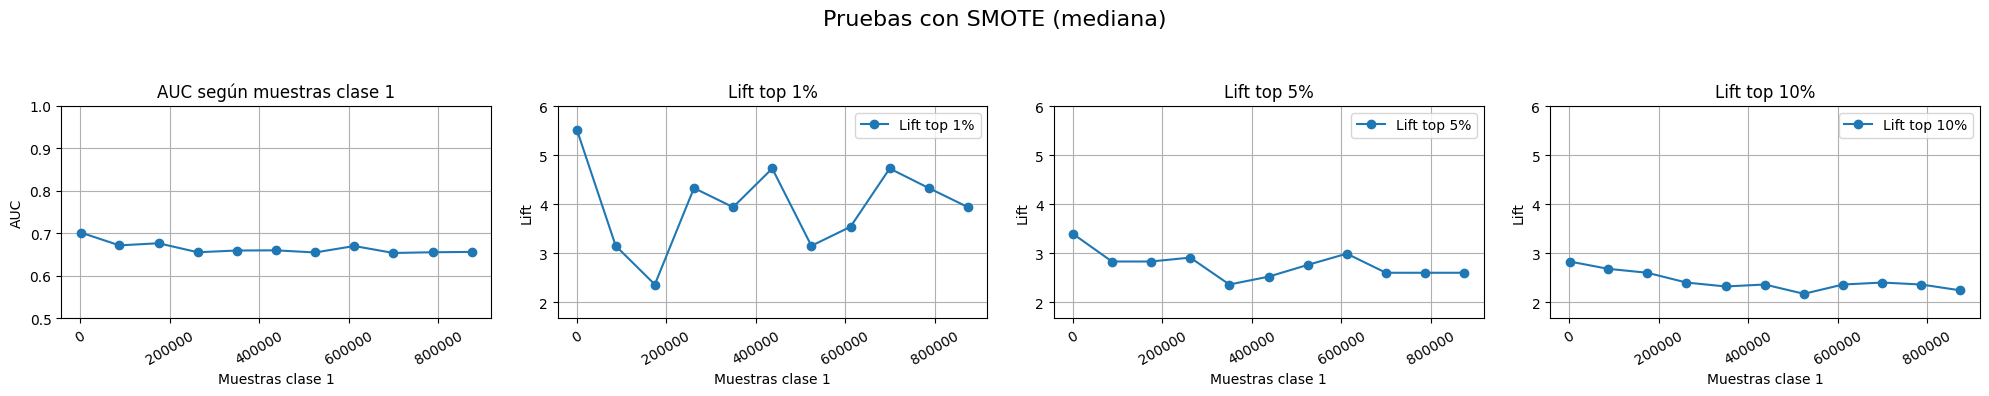

In [20]:
n_lifts = len(lifts_porcentajes)
fig, axes = plt.subplots(ncols=1 + n_lifts, figsize=(5 * (1 + n_lifts), 4))

# Título general de la figura
fig.suptitle("Pruebas con SMOTE (mediana)", fontsize=16)

# Gráfico del AUC
axes[0].plot(ejemplos1, auc_scores, marker='o')
axes[0].set_title("AUC según muestras clase 1")
axes[0].set_xlabel("Muestras clase 1")
axes[0].set_ylabel("AUC")
axes[0].set_ylim(0.5, 1)  # Ahora empieza en 0.5
axes[0].set_yticks([round(i * 0.1, 1) for i in range(5, 11)])  # ticks de 0.5 a 1.0 en pasos de 0.1
# axes[0].xticks(ejemplos1[::2],rotation=-60)  # Inclinar etiquetas del eje X
axes[0].tick_params(axis='x', rotation=30)  # Inclinar etiquetas del eje X
axes[0].grid(True)

# --- Calcular min y max global de Lift ---
all_lift_values = []
for lift_vals in lifts_porcentajes.values():
    all_lift_values.extend(lift_vals)

min_lift_global = min(all_lift_values)
max_lift_global = max(all_lift_values)

# Gráficos de los lifts
for i, (p, lift_vals) in enumerate(lifts_porcentajes.items(), start=1):
    axes[i].plot(ejemplos1, lift_vals, marker='o', label=f"Lift top {p}%")
    axes[i].set_title(f"Lift top {p}%")
    axes[i].set_xlabel("Muestras clase 1")
    axes[i].set_ylabel("Lift")
    axes[i].set_ylim(min_lift_global-0.5, max_lift_global+0.5)  # Usar min y max global
    # axes[i].xticks(ejemplos1[::2],rotation=-60)  # Inclinar etiquetas del eje X
    axes[i].tick_params(axis='x', rotation=30)  # Inclinar etiquetas del eje X
    axes[i].grid(True)
    axes[i].legend()

# Ajustar diseño para dejar espacio al título
plt.tight_layout(rect=[0, 0, 1, 0.92])
plt.show()


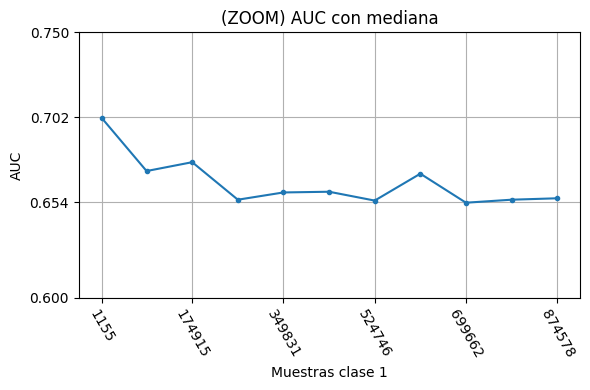

In [21]:
# Nueva gráfica solo del AUC con ylim personalizado
plt.figure(figsize=(6, 4))
plt.plot(ejemplos1, auc_scores, marker='o', markersize=3)
plt.title("(ZOOM) AUC con mediana")
plt.xlabel("Muestras clase 1")
plt.ylabel("AUC")
# plt.ylim(0.6, 0.75)  # Límite de Y ajustado
# plt.yticks([round(i * 0.05, 2) for i in range(11, 17)])  # Opcional: ticks de 0.55 a 0.8
plt.yticks([0.6, 0.75, round(max(auc_scores), 3),round(min(auc_scores), 3)])
plt.xticks(ejemplos1[::2],rotation=-60)  # Inclinar etiquetas del eje X
plt.grid(True)
plt.tight_layout()
plt.show()


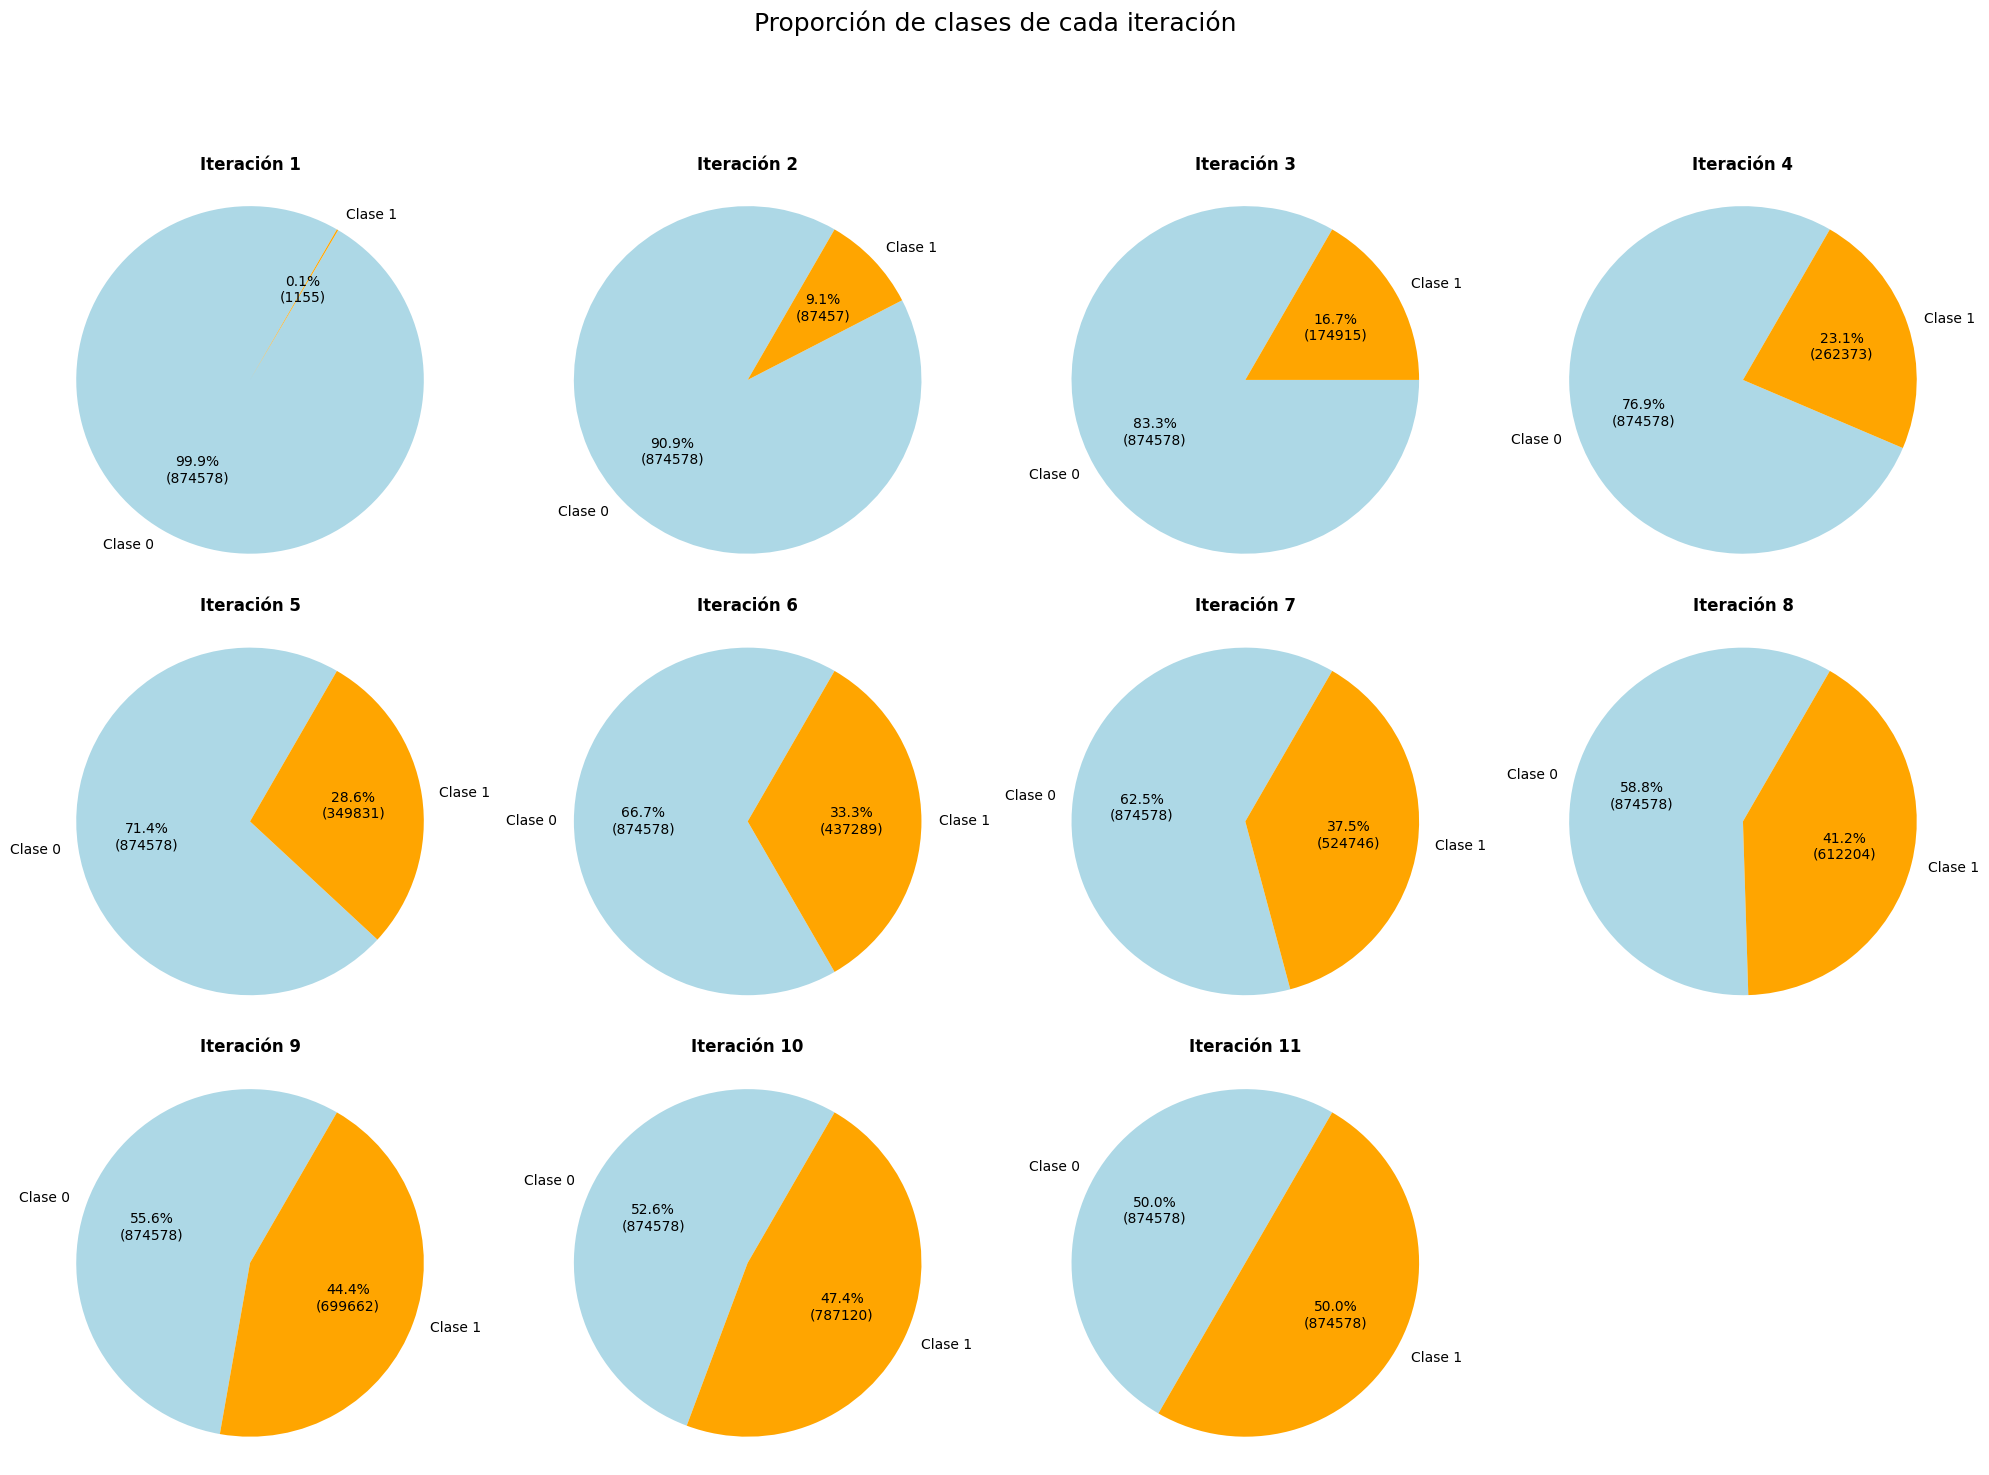

In [ ]:
counter = Counter(y_train)

# Número fijo de ejemplos de clase 0
n_clase_0 = counter[0]
# Total de gráficos
total = len(ejemplos1)
ncols = 4
nrows = math.ceil(total / ncols)

# Crear subplots
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(5 * ncols, 5 * nrows))

# Asegurarse de que axes es un array plano iterable
axes = axes.flatten()

# Título general
fig.suptitle("Proporción de clases de cada iteración", fontsize=18)

# Función para formato combinado de % y cantidad
def make_autopct(sizes):
    def autopct(pct):
        total = sum(sizes)
        val = int(round(pct * total / 100.0))
        return f'{pct:.1f}%\n({val})'
    return autopct

for i, n_clase_1 in enumerate(ejemplos1):
    sizes = [n_clase_0, n_clase_1]
    labels = ['Clase 0', 'Clase 1']
    colors = ['lightblue', 'orange']
    axes[i].pie(
        sizes, 
        labels=labels, 
        autopct=make_autopct(sizes), 
        colors=colors, 
        startangle=60
    )
    axes[i].axis('equal')
    axes[i].set_title(f'Iteración {i+1}', fontsize=12, fontweight='bold')

# Eliminar subplots sobrantes si los hay
for j in range(len(ejemplos1), len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout(rect=[0, 0, 1, 0.92])
plt.show()


## Smote con imputación usando el most_frequent

In [ ]:
ejemplos1, auc_scores, lifts_porcentajes = loop_smote_entrenamiento(
    X_train, y_train, X_val, y_val,
    optimizar_xgboost_random_search=optimizar_xgboost_random_search,
    evaluar_modelo=evaluar_modelo,
    estrategia_imputacion="most_frequent",
    ratios=np.arange(0, 1.01, 0.1),  # de 0 a 1 en pasos de 0.1
    n_iter_xgb=10,
    cv_xgb=2,
    verbose=True
)



### Ratio SMOTE: 0.0
Clase 0: 874578, Clase 1: 1155, scale_pos_weight=757.210
Fitting 2 folds for each of 10 candidates, totalling 20 fits
Tiempo de ejecución para ratio 0.0 -> 0:10:37.722449
	ROC AUC: 0.7026
	Lift @ top 1%: 3.15x
	Lift @ top 5%: 3.46x
	Lift @ top 10%: 3.15x

### Ratio SMOTE: 0.1
Clase 0: 874578, Clase 1: 87457, scale_pos_weight=10.000
Fitting 2 folds for each of 10 candidates, totalling 20 fits
Tiempo de ejecución para ratio 0.1 -> 0:10:19.943875
	ROC AUC: 0.6639
	Lift @ top 1%: 1.97x
	Lift @ top 5%: 2.52x
	Lift @ top 10%: 2.28x

### Ratio SMOTE: 0.2
Clase 0: 874578, Clase 1: 174915, scale_pos_weight=5.000
Fitting 2 folds for each of 10 candidates, totalling 20 fits
Tiempo de ejecución para ratio 0.2 -> 0:10:33.886844
	ROC AUC: 0.6476
	Lift @ top 1%: 3.54x
	Lift @ top 5%: 2.36x
	Lift @ top 10%: 2.44x

### Ratio SMOTE: 0.3
Clase 0: 874578, Clase 1: 262373, scale_pos_weight=3.333
Fitting 2 folds for each of 10 candidates, totalling 20 fits
Tiempo de ejecución para rati

### Visualización de métricas

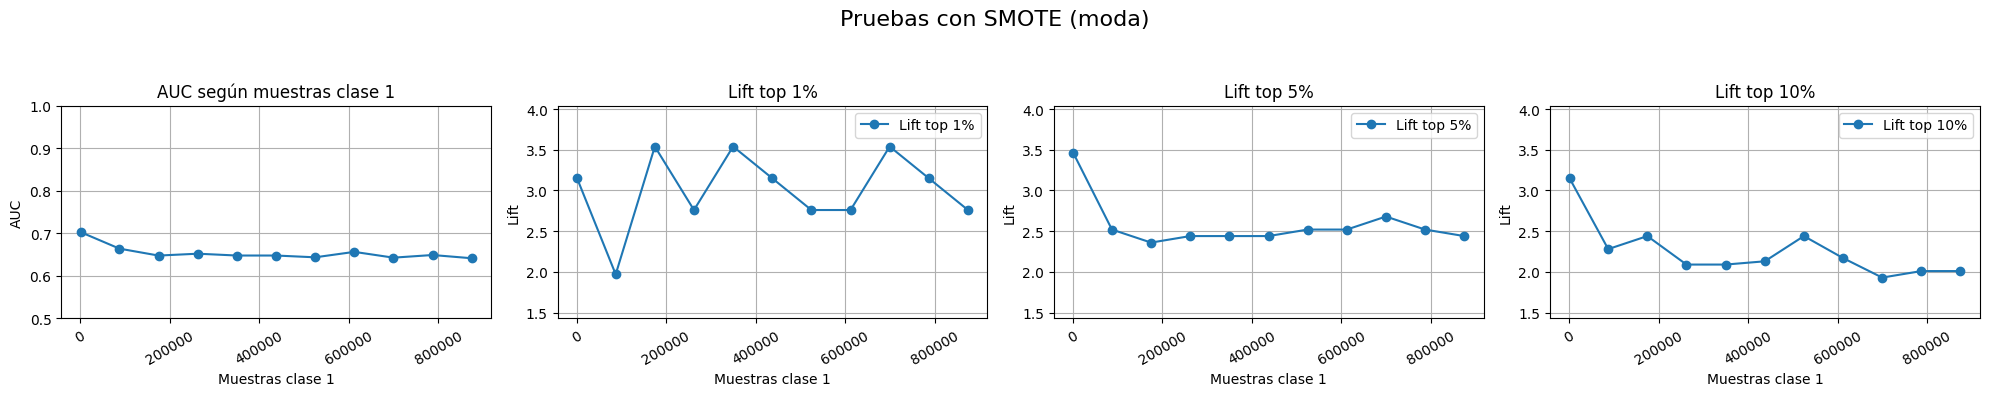

In [25]:
n_lifts = len(lifts_porcentajes)
fig, axes = plt.subplots(ncols=1 + n_lifts, figsize=(5 * (1 + n_lifts), 4))

# Título general de la figura
fig.suptitle("Pruebas con SMOTE (moda)", fontsize=16)

# Gráfico del AUC
axes[0].plot(ejemplos1, auc_scores, marker='o')
axes[0].set_title("AUC según muestras clase 1")
axes[0].set_xlabel("Muestras clase 1")
axes[0].set_ylabel("AUC")
axes[0].set_ylim(0.5, 1)  # Ahora empieza en 0.5
axes[0].set_yticks([round(i * 0.1, 1) for i in range(5, 11)])  # ticks de 0.5 a 1.0 en pasos de 0.1
# axes[0].xticks(ejemplos1[::2],rotation=-60)  # Inclinar etiquetas del eje X
axes[0].tick_params(axis='x', rotation=30)  # Inclinar etiquetas del eje X
axes[0].grid(True)

# --- Calcular min y max global de Lift ---
all_lift_values = []
for lift_vals in lifts_porcentajes.values():
    all_lift_values.extend(lift_vals)

min_lift_global = min(all_lift_values)
max_lift_global = max(all_lift_values)

# Gráficos de los lifts
for i, (p, lift_vals) in enumerate(lifts_porcentajes.items(), start=1):
    axes[i].plot(ejemplos1, lift_vals, marker='o', label=f"Lift top {p}%")
    axes[i].set_title(f"Lift top {p}%")
    axes[i].set_xlabel("Muestras clase 1")
    axes[i].set_ylabel("Lift")
    axes[i].set_ylim(min_lift_global-0.5, max_lift_global+0.5)  # Usar min y max global
    # axes[i].xticks(ejemplos1[::2],rotation=-60)  # Inclinar etiquetas del eje X
    axes[i].tick_params(axis='x', rotation=30)  # Inclinar etiquetas del eje X
    axes[i].grid(True)
    axes[i].legend()

# Ajustar diseño para dejar espacio al título
plt.tight_layout(rect=[0, 0, 1, 0.92])
plt.show()


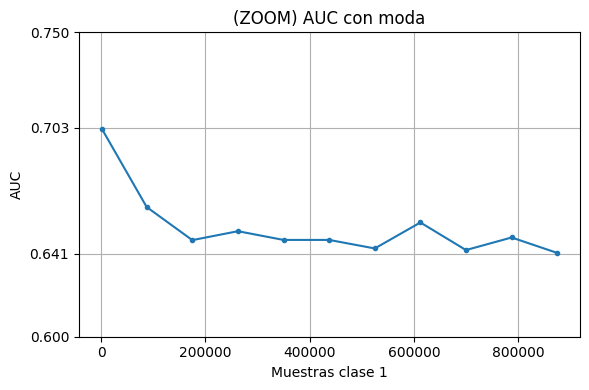

In [26]:
# Nueva gráfica solo del AUC con ylim personalizado
plt.figure(figsize=(6, 4))
plt.plot(ejemplos1, auc_scores, marker='o', markersize=3)
plt.title("(ZOOM) AUC con moda")
plt.xlabel("Muestras clase 1")
plt.ylabel("AUC")
# plt.ylim(0.6, 0.75)  # Límite de Y ajustado
# plt.yticks([round(i * 0.05, 2) for i in range(11, 17)])  # Opcional: ticks de 0.55 a 0.8
plt.yticks([0.6, 0.75, round(max(auc_scores), 3),round(min(auc_scores), 3)])
# plt.xticks(ejemplos1[::2],rotation=-60)  # Inclinar etiquetas del eje X
plt.grid(True)
plt.tight_layout()
plt.show()


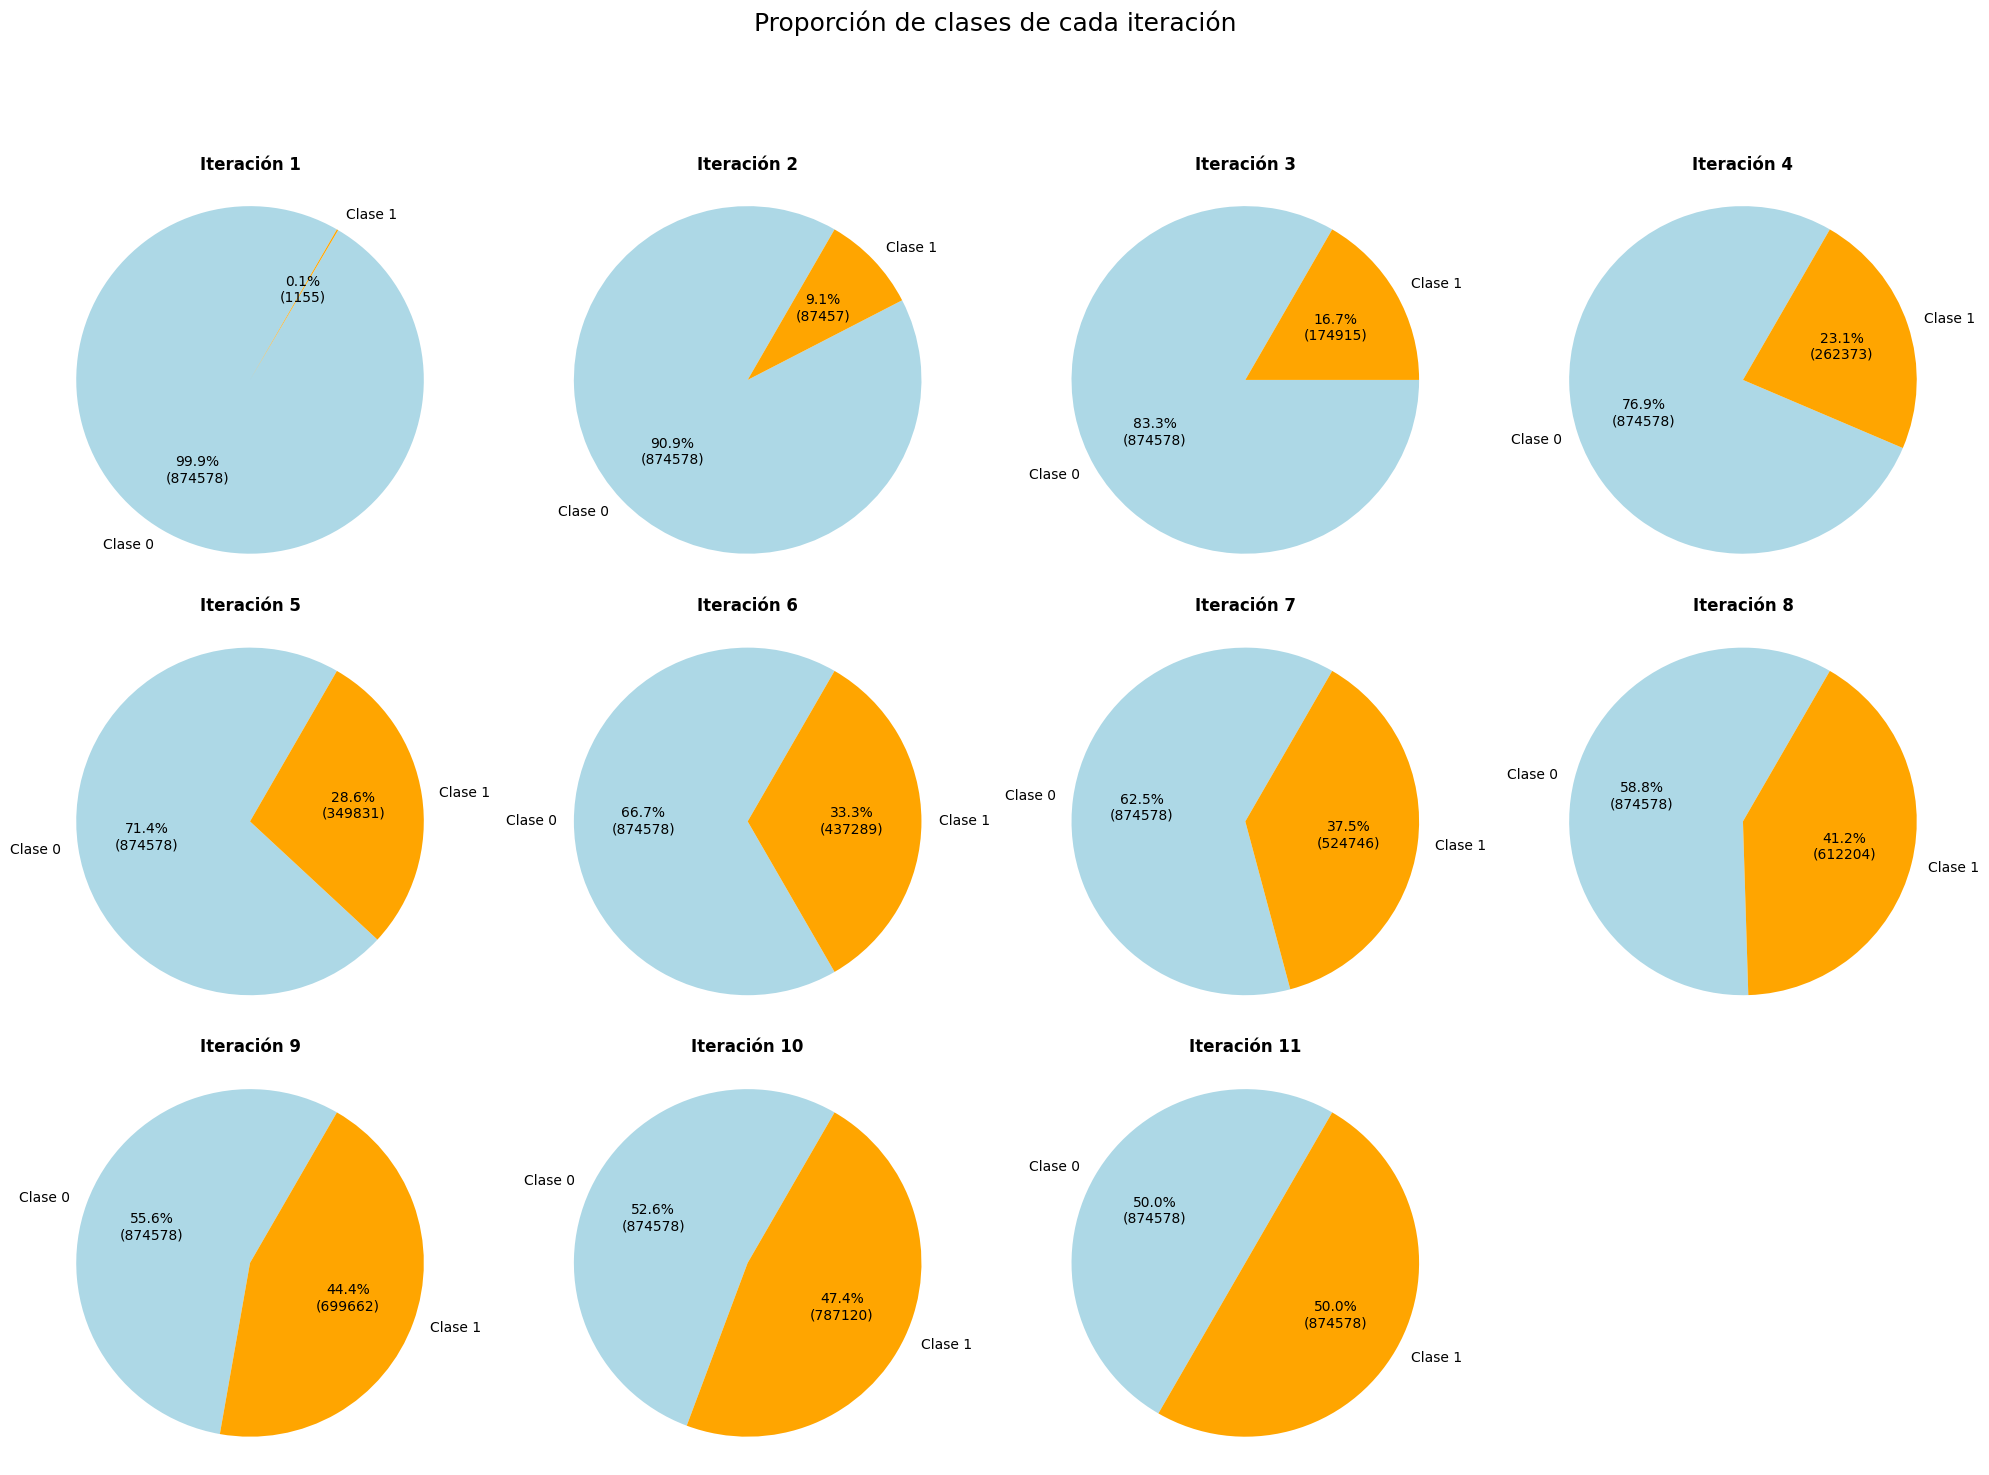

In [ ]:
counter = Counter(y_train)

# Número fijo de ejemplos de clase 0
n_clase_0 = counter[0]
# Total de gráficos
total = len(ejemplos1)
ncols = 4
nrows = math.ceil(total / ncols)

# Crear subplots
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(5 * ncols, 5 * nrows))

# Asegurarse de que axes es un array plano iterable
axes = axes.flatten()

# Título general
fig.suptitle("Proporción de clases de cada iteración", fontsize=18)

# Función para formato combinado de % y cantidad
def make_autopct(sizes):
    def autopct(pct):
        total = sum(sizes)
        val = int(round(pct * total / 100.0))
        return f'{pct:.1f}%\n({val})'
    return autopct

for i, n_clase_1 in enumerate(ejemplos1):
    sizes = [n_clase_0, n_clase_1]
    labels = ['Clase 0', 'Clase 1']
    colors = ['lightblue', 'orange']
    axes[i].pie(
        sizes, 
        labels=labels, 
        autopct=make_autopct(sizes), 
        colors=colors, 
        startangle=60
    )
    axes[i].axis('equal')
    axes[i].set_title(f'Iteración {i+1}', fontsize=12, fontweight='bold')

# Eliminar subplots sobrantes si los hay
for j in range(len(ejemplos1), len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout(rect=[0, 0, 1, 0.92])
plt.show()
